In [1]:
from pathlib import Path
import os
import json
import sys
import optuna
from optuna.samplers import TPESampler
from stable_baselines3 import DQN
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import ProgressBarCallback
import numpy as np
import torch
import random
import yaml
import pandas as pd
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
path_to_src = Path(Path(os.getcwd()).parent, 'src')
sys.path.append(str(path_to_src))
from enviroment import StockTradingEnvDSR
from agents import LinearFeatureExtractor, RNNFeatureExtractor, LSTMExtractor, MLPFeatureExtractor
from utils import get_data, get_scaled_data_new, get_time_data_new, prepare_aligned_data, daily_portfolio_return, statistics_calc
from optimization_PPO import train_single_model, sliding_window_training, objective_ppo, optimize_config, set_seeds, create_env
import warnings
warnings.filterwarnings('ignore')

# Обучение и сохранение лучшей модели

In [39]:
CONFIG = {
    "ticker": "AAPL",
    "model_type": "Linear",
    "window_size": 90,
    "price_column": 3,
    "num_actions": 5,
    "training_mode": "sliding_window",
    "sliding_window_config": {
        "train_years": 5,
        "val_years": 1,
        "test_years": 1,
        "start_year": 2010,
        "n_windows": 5,
        "n_envs": 1,
        "n_agents": 3
    },
    "seed": 42,
    "ppo_params": {
        "n_steps": 756,
        "batch_size": 1260,
        "n_epochs": 16,
        "gamma": 0.9,
        "gae_lambda": 0.9,
        "clip_range": 0.25,
        "learning_rate": 3e-4,
        "ent_coef": 0.01,
        "vf_coef": 0.5,
        "max_grad_norm": 0.5,
        "tensorboard_log": "logs/"
    },
    "total_timesteps": 50000,
    # Периоды для одиночного режима
    "train_period": ("2010-11-13", "2023-01-11"),
    "val_period": ("2023-01-11", "2025-03-19"),
    "test_period": None,  # Для одиночного режима
    "optuna": {
        "n_trials": 10,
        "timeout": 100000,  
        "direction": "maximize"
    }
}


In [40]:
def prepare_aligned_data2(ticker, config, interval='B'):
    """Возвращает синхронизированные данные"""
    raw_data = get_data(ticker, interval=interval)
    
    # Вычисляем признаки для ВСЕХ данных
    scaled_data = get_scaled_data_new(raw_data)
    time_data = get_time_data_new(scaled_data.index)
    
    raw_data = raw_data.loc[scaled_data.index]
    print('feature finance:', scaled_data.columns)
    print('feature time:', time_data.columns)
    # print(raw_data.shape, scaled_data.shape, time_data.shape)
    # Фильтруем по датам из конфига
    train_start, train_end = config["train_period"]
    val_start, val_end = config["val_period"]
    full_mask = (raw_data.index >= val_start) & (raw_data.index <= val_end)
    
    # Применяем маску ко всем данным
    filtered_raw = raw_data.loc[full_mask]
    filtered_scaled = scaled_data.loc[full_mask]
    filtered_time = time_data.loc[full_mask]

    # Синхронизация индексов после dropna
    common_idx = filtered_scaled.index.intersection(filtered_time.index)
    filtered_raw = filtered_raw.loc[common_idx]
    filtered_scaled = filtered_scaled.loc[common_idx]
    filtered_time = filtered_time.loc[common_idx]
    
    return (
        filtered_raw,
        filtered_scaled,
        filtered_time,
        common_idx
    )

In [41]:
def test_on_val(model_path, config):
    set_seeds(config["seed"])
    raw_data, scaled_data, time_data, _ = prepare_aligned_data2(
        config["ticker"], config
    )
    
    env_val = create_env(
        raw_data, scaled_data, time_data, config,
        mode='val', n_envs=1
    )

    model = PPO.load(model_path)
    returns, b_h_ret, positions = daily_portfolio_return(env_val, model)
    positions = [-1 + 2.0 / (config['num_actions'] - 1) * pos for pos in positions]
    metrics = statistics_calc(returns, b_h_ret, plot=True, mode='validation', ticker=config['ticker'], positions=positions)
    return metrics

In [42]:
set_seeds(CONFIG['seed'])

In [43]:
def update_config(old_dct, new_dct):
    for key, value in old_dct.items():
        if key in new_dct:
            old_dct[key] = new_dct[key]
        else:
            if isinstance(value, dict):
                update_config(value, new_dct)

In [44]:
with open("best_params_for_all_assets.yaml", "r") as f:
    best_params_for_all_assets = yaml.safe_load(f)

In [45]:
update_config(CONFIG, best_params_for_all_assets)

In [35]:
assets = ['AAPL', 'AMZN', 'MSFT', 'JPM'] # список активов на которых мы будем тестировать лучшие модели

In [36]:
PATH_TO_MODELS = Path(os.getcwd()).parent / 'final models'

Output()

Output()

Агент 1 Средняя награда: -25.2848
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 253.9300
Обучение агента 3/3


Output()

Агент 3 Средняя награда: 212.6958

Окно 2/5 (Год: 2011)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: -9.8798
Обучение агента 2/3


Output()

Агент 2 Средняя награда: -26.7513
Обучение агента 3/3


Output()

Агент 3 Средняя награда: -20.4819

Окно 3/5 (Год: 2012)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: -9.0288
Обучение агента 2/3


Output()

Агент 2 Средняя награда: -6.9388
Обучение агента 3/3


Output()

Агент 3 Средняя награда: -5.3548

Окно 4/5 (Год: 2013)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: -18.8967
Обучение агента 2/3


Output()

Агент 2 Средняя награда: -37.0272
Обучение агента 3/3


Output()

Агент 3 Средняя награда: -39.0439

Окно 5/5 (Год: 2014)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 90.2553
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 10.0116
Обучение агента 3/3


Агент 3 Средняя награда: 35.2087
Shape of data: (4040, 6) 2010-01-04 00:00:00 2025-06-27 00:00:00
feature finance: Index(['f_log_ret', 'f_vol20', 'f_vol60', 'f_vol20/vol60', 'f_ema_10',
       'f_ema_90', 'f_rsi', 'f_macd_line', 'f_macd_signal'],
      dtype='object')
feature time: Index(['day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin',
       'day_of_month_cos', 'day_of_year_sin', 'day_of_year_cos',
       'week_of_year_sin', 'week_of_year_cos', 'month_sin', 'month_cos',
       'quarter_sin', 'quarter_cos', 'is_month_end'],
      dtype='object')


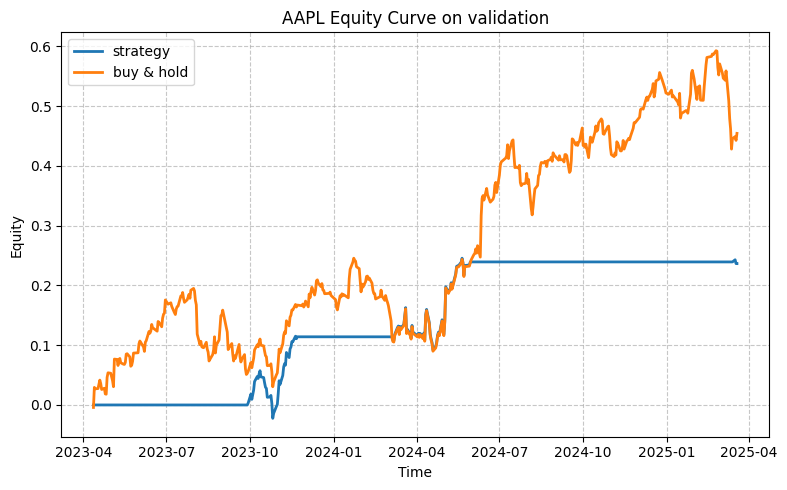

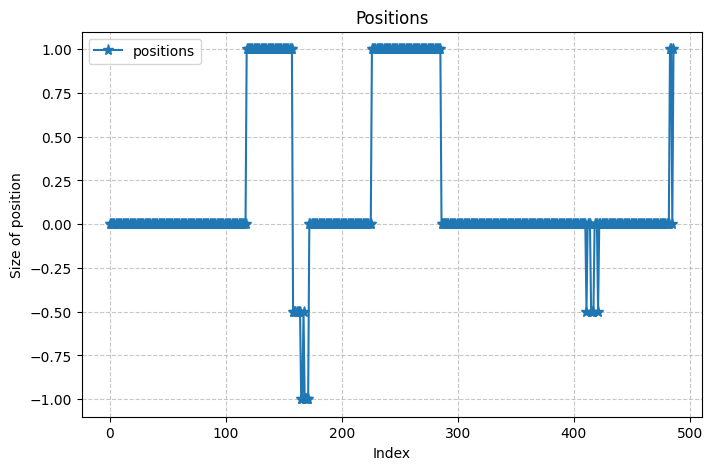

Metrics on validation:
Sharpe ratio: 1.5623, annual return: 0.1853, volatility: 0.1186


Output()

Shape of data: (4040, 6) 2010-01-04 00:00:00 2025-06-27 00:00:00
feature finance: Index(['f_log_ret', 'f_vol20', 'f_vol60', 'f_vol20/vol60', 'f_ema_10',
       'f_ema_90', 'f_rsi', 'f_macd_line', 'f_macd_signal'],
      dtype='object')
feature time: Index(['day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin',
       'day_of_month_cos', 'day_of_year_sin', 'day_of_year_cos',
       'week_of_year_sin', 'week_of_year_cos', 'month_sin', 'month_cos',
       'quarter_sin', 'quarter_cos', 'is_month_end'],
      dtype='object')

Окно 1/5 (Год: 2010)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 4.8102
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 97.0563
Обучение агента 3/3


Output()

Агент 3 Средняя награда: -107.5842

Окно 2/5 (Год: 2011)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: -17.5086
Обучение агента 2/3


Output()

Агент 2 Средняя награда: -5.8338
Обучение агента 3/3


Output()

Агент 3 Средняя награда: 128.1144

Окно 3/5 (Год: 2012)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: -10.4881
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 6.7942
Обучение агента 3/3


Output()

Агент 3 Средняя награда: -13.7180

Окно 4/5 (Год: 2013)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 25.5661
Обучение агента 2/3


Output()

Агент 2 Средняя награда: -55.3826
Обучение агента 3/3


Output()

Агент 3 Средняя награда: 55.2956

Окно 5/5 (Год: 2014)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: -21.9638
Обучение агента 2/3


Output()

Агент 2 Средняя награда: -13.3030
Обучение агента 3/3


Агент 3 Средняя награда: -10.9173
Shape of data: (4040, 6) 2010-01-04 00:00:00 2025-06-27 00:00:00
feature finance: Index(['f_log_ret', 'f_vol20', 'f_vol60', 'f_vol20/vol60', 'f_ema_10',
       'f_ema_90', 'f_rsi', 'f_macd_line', 'f_macd_signal'],
      dtype='object')
feature time: Index(['day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin',
       'day_of_month_cos', 'day_of_year_sin', 'day_of_year_cos',
       'week_of_year_sin', 'week_of_year_cos', 'month_sin', 'month_cos',
       'quarter_sin', 'quarter_cos', 'is_month_end'],
      dtype='object')


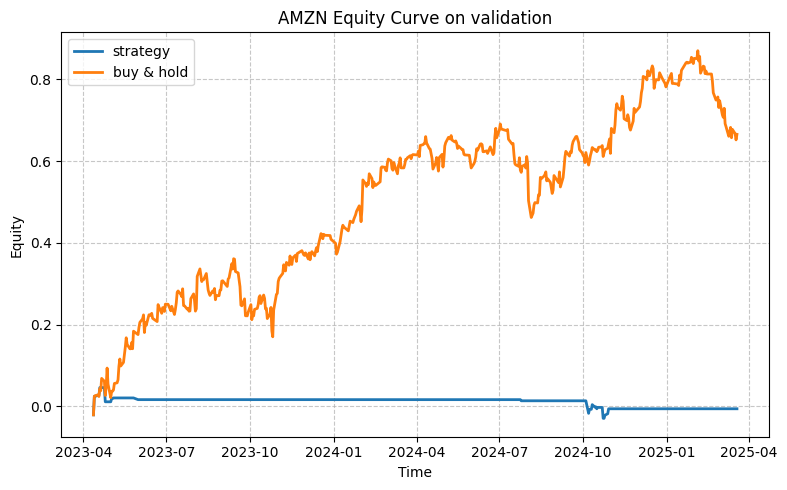

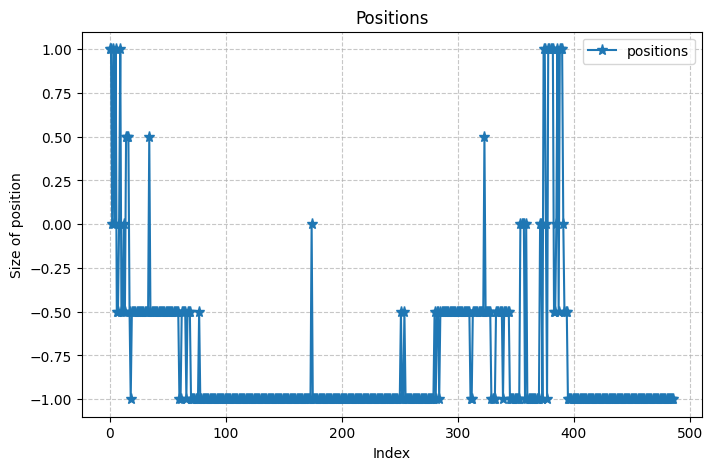

Metrics on validation:
Sharpe ratio: -0.0701, annual return: -0.0050, volatility: 0.0707


Output()

Shape of data: (4040, 6) 2010-01-04 00:00:00 2025-06-27 00:00:00
feature finance: Index(['f_log_ret', 'f_vol20', 'f_vol60', 'f_vol20/vol60', 'f_ema_10',
       'f_ema_90', 'f_rsi', 'f_macd_line', 'f_macd_signal'],
      dtype='object')
feature time: Index(['day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin',
       'day_of_month_cos', 'day_of_year_sin', 'day_of_year_cos',
       'week_of_year_sin', 'week_of_year_cos', 'month_sin', 'month_cos',
       'quarter_sin', 'quarter_cos', 'is_month_end'],
      dtype='object')

Окно 1/5 (Год: 2010)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 56.8797
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 107.2057
Обучение агента 3/3


Output()

Агент 3 Средняя награда: 89.6695

Окно 2/5 (Год: 2011)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: -81.4362
Обучение агента 2/3


Output()

Агент 2 Средняя награда: -92.3189
Обучение агента 3/3


Output()

Агент 3 Средняя награда: -82.1576

Окно 3/5 (Год: 2012)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: -24.4698
Обучение агента 2/3


Output()

Агент 2 Средняя награда: -17.6402
Обучение агента 3/3


Output()

Агент 3 Средняя награда: -17.6827

Окно 4/5 (Год: 2013)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 45.8055
Обучение агента 2/3


Output()

Output()

Агент 3 Средняя награда: -8.4140

Окно 5/5 (Год: 2014)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: -14.0409
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 6.0593
Обучение агента 3/3


Агент 3 Средняя награда: -9.5574
Shape of data: (4040, 6) 2010-01-04 00:00:00 2025-06-27 00:00:00
feature finance: Index(['f_log_ret', 'f_vol20', 'f_vol60', 'f_vol20/vol60', 'f_ema_10',
       'f_ema_90', 'f_rsi', 'f_macd_line', 'f_macd_signal'],
      dtype='object')
feature time: Index(['day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin',
       'day_of_month_cos', 'day_of_year_sin', 'day_of_year_cos',
       'week_of_year_sin', 'week_of_year_cos', 'month_sin', 'month_cos',
       'quarter_sin', 'quarter_cos', 'is_month_end'],
      dtype='object')


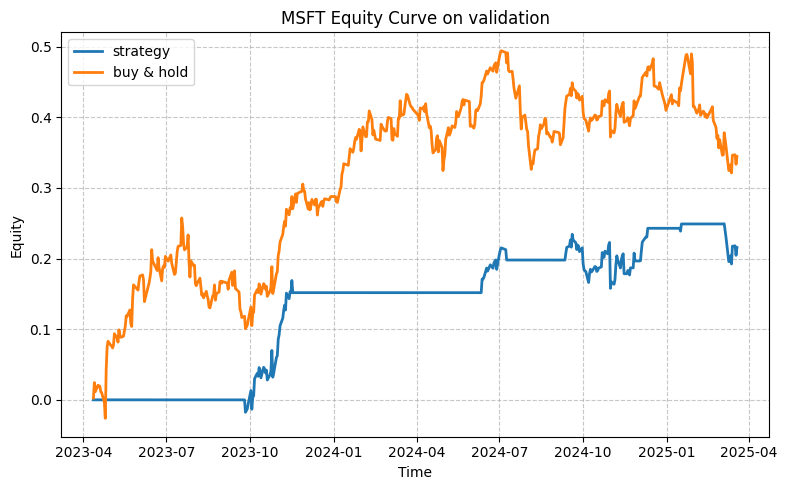

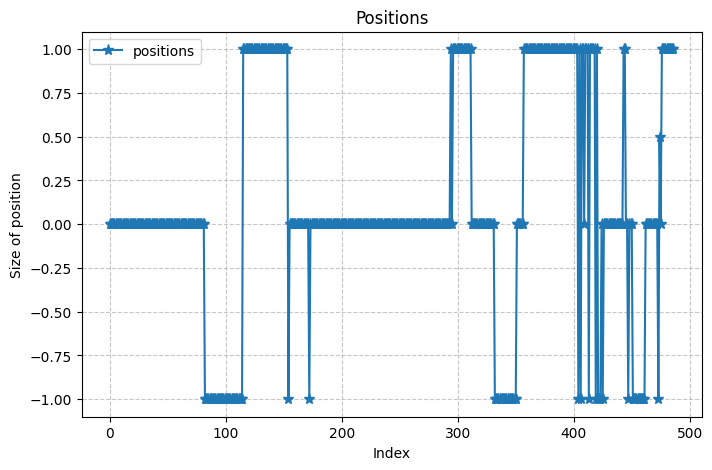

Metrics on validation:
Sharpe ratio: 1.2668, annual return: 0.1690, volatility: 0.1334


Output()

Shape of data: (4040, 6) 2010-01-04 00:00:00 2025-06-27 00:00:00
feature finance: Index(['f_log_ret', 'f_vol20', 'f_vol60', 'f_vol20/vol60', 'f_ema_10',
       'f_ema_90', 'f_rsi', 'f_macd_line', 'f_macd_signal'],
      dtype='object')
feature time: Index(['day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin',
       'day_of_month_cos', 'day_of_year_sin', 'day_of_year_cos',
       'week_of_year_sin', 'week_of_year_cos', 'month_sin', 'month_cos',
       'quarter_sin', 'quarter_cos', 'is_month_end'],
      dtype='object')

Окно 1/5 (Год: 2010)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: -166.6499
Обучение агента 2/3


Output()

Агент 2 Средняя награда: -28.6974
Обучение агента 3/3


Output()

Агент 3 Средняя награда: 42.2873

Окно 2/5 (Год: 2011)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 7.2998
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 11.6005
Обучение агента 3/3


Агент 3 Средняя награда: 20.7583

Окно 3/5 (Год: 2012)
Обучение агента 1/3


Output()

Output()

Агент 1 Средняя награда: 49.8669
Обучение агента 2/3


Output()

Агент 2 Средняя награда: -190.9133
Обучение агента 3/3


Output()

Агент 3 Средняя награда: -163.0602

Окно 4/5 (Год: 2013)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: -22.8824
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 16.4727
Обучение агента 3/3


Output()

Агент 3 Средняя награда: -28.0012

Окно 5/5 (Год: 2014)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 0.8635
Обучение агента 2/3


Output()

Агент 2 Средняя награда: -5.2462
Обучение агента 3/3


Агент 3 Средняя награда: -4.1047
Shape of data: (4040, 6) 2010-01-04 00:00:00 2025-06-27 00:00:00
feature finance: Index(['f_log_ret', 'f_vol20', 'f_vol60', 'f_vol20/vol60', 'f_ema_10',
       'f_ema_90', 'f_rsi', 'f_macd_line', 'f_macd_signal'],
      dtype='object')
feature time: Index(['day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin',
       'day_of_month_cos', 'day_of_year_sin', 'day_of_year_cos',
       'week_of_year_sin', 'week_of_year_cos', 'month_sin', 'month_cos',
       'quarter_sin', 'quarter_cos', 'is_month_end'],
      dtype='object')


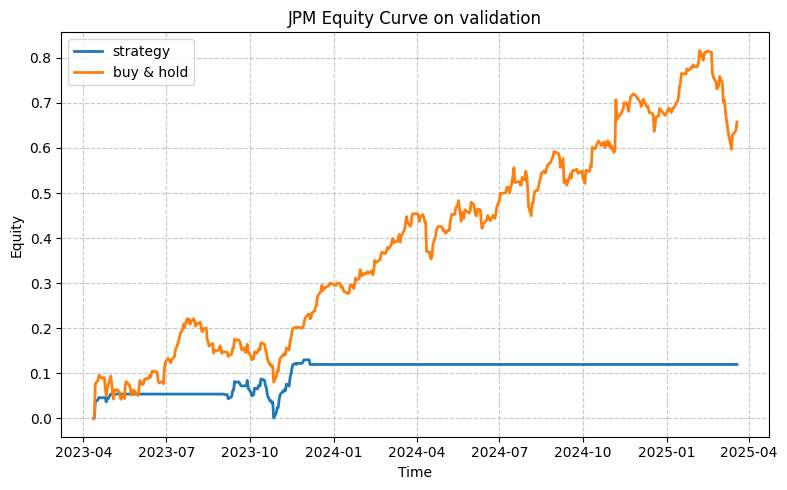

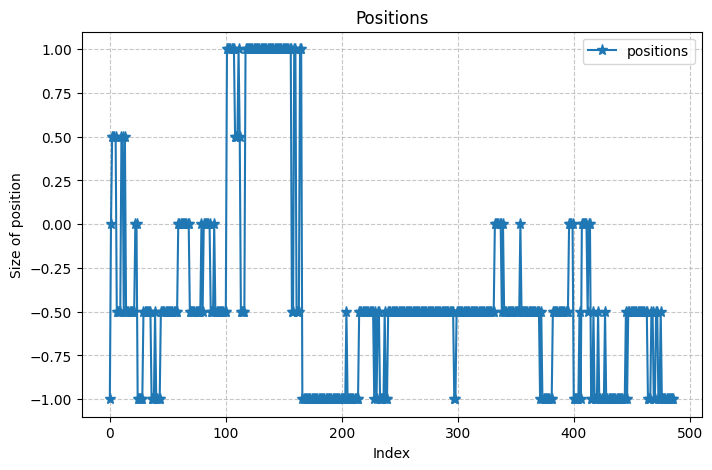

Metrics on validation:
Sharpe ratio: 1.2479, annual return: 0.0936, volatility: 0.0750


In [46]:
all_metrics = pd.DataFrame(
    index=assets,
    columns=['Sharpe ratio', 'Annual return', 'Volatility',
            'bh Sharpe ratio', 'bh Annual return', 'bh Volatility']
)

for asset in assets:
    CONFIG['ticker'] = asset
    cur_metrics, best_model = sliding_window_training(CONFIG, out_of_sample=True) # обучаем только на трейне (train_period)
    cur_path = str(PATH_TO_MODELS / f'best_model_{asset}.zip')
    best_model.save(cur_path)

    cur_metrics_val = test_on_val(cur_path, CONFIG)
    
    for col in cur_metrics_val.columns:
        all_metrics.loc[asset, col] = cur_metrics_val[col].values[0]

In [47]:
all_metrics

,Sharpe ratio,Annual return,Volatility,bh Sharpe ratio,bh Annual return,bh Volatility
AAPL,1.562267,0.185333,0.118631,1.352534,0.356117,0.263296
AMZN,-0.070116,-0.004956,0.070689,1.471822,0.521712,0.354467
MSFT,1.266773,0.169021,0.133426,1.015116,0.27002,0.265999
JPM,1.247946,0.09363,0.075027,1.957927,0.515618,0.263349
